In [1]:
# NOTES - TAKE 2
# for now, use max captured exposure as zmax, fix later
# obtain pixel value Z from camera with expohttp://192.168.7.2:8888/notebooks/part5_2_hdr.ipynb#sure X, exposure time dt
# want to get irradiance E, given X and dt, E = X / dt
# Z = f(X) = f(E * dt)
# invf(Z) = E * dt
# ln(invf(Z)) = ln(E) + ln(dt)
# g(a) = ln(invf(a)) --> g(Z) = ln(E) + ln(dt)
# ln(E) = g(Z) - ln(dt)
# do this for all Z_ij, E_i, dt_j (pixel i in image j)
# Goal: compute radiance of each pixel, given g, Z, dt

In [26]:
## Initialize everything
import math
import png
from PIL import Image
%run common.ipynb

Importing libraries...
Done!
Initialize camera and default settings...
Done!
Define functions needed to capture images...
Done!
Generating patterns for projector...
Done!


In [98]:
# FUNCTIONS

### HELPER FUNCTIONS ###

# helper function to plot functions for debugging
# Params:
#   f - function to plot
#   zmin, zmax - x-axis range
#   step - x-axis step
def plot_func(f, zmin, zmax, step):
    vals = []
    for x in numpy.linspace(zmin, zmax, step):
        vals += [f(x)]
    plt.plot(vals); plt.show();

# some helper functions to get individual color channels from raw image
# Params: <image> must be numpy.array
# Return: color channel
def get_red_image(image):
    return image[1::2,1::2];
def get_blue_image(image):
    return image[0::2,0::2];
def get_green_image(image):
    B = image[0::2,1::2]; #green1
    C = image[1::2,0::2]; #green2
    return B/2 + C/2

# return array of pixel values corresponding to exposure times and max pixel value
def get_calibration_curve_from_images(images, p0=100, p1=150):
    pixel_values = []
    # store average pixel value for each image
    max_pixel_value = 0
    for i in range(len(images)):
        img = images[i]
        pixel_values += [numpy.mean(numpy.mean(img[p0:p1,p0:p1]))]; # y vals
        if (pixel_values[-1] > max_pixel_value):
            max_pixel_value = pixel_values[-1]
        
    print("max pixel value=" + str(max_pixel_value))
    return [pixel_values, max_pixel_value]

# show image with values between zmin and zmax
def show_clipped(img, zmin, zmax):
    print("show clipped img, min=" + str(zmin) + ", max=" + str(zmax))
    plt.imshow(numpy.clip(new_image,zmin,zmax)); plt.show();
    
# Convert raw image to color image(numpy array)
def raw2color(image):
    image = 1.0*image
    A = image[0::2,0::2]; #blue
    B = image[0::2,1::2]; #green1
    C = image[1::2,0::2]; #green2
    D = image[1::2,1::2]; #red
    color_image = numpy.dstack((D, (B/2+C/2), A));
    return color_image

# Does same thing as raw2color except clamping by 1 and desaturating by 1/3 for each channel 
# <image> must but numpy array
def raw2color_2(image):
    image = 1.0*image
    A = image[0::2,0::2];
    B = image[0::2,1::2];
    C = image[1::2,0::2];
    D = image[1::2,1::2];
    m = 1
    x=3
    red = numpy.clip(D/x, 0, m);
    blue = numpy.clip(A/x, 0, m);
    green = numpy.clip((B/2+C/2)/x, 0, m);
    color_image = numpy.clip(numpy.dstack((red, green, blue)),0,4);
    return color_image

### HDR FUNCTIONS ####

# return array of images at different exposures and corresponding exposure times
def get_images(num_exposures, save=False):
    exposure_times = []
    tmin = 1
    tmax = 10
    
    # adjust these for better noise reduction
    pixy.set_gamma(1);
    pixy.set_gain(32);
    
    images = []
    # capture images at various exposures (50 evenly spaced vals btwn 1 and 10)
    for x in numpy.linspace(tmin, tmax, num_exposures):
        pixy.set_exposure(x);
        img = get_raw_image();
        img = get_raw_image(); # need to call twice for exposure change to take effect
        images += [1.0*img]
        exposure_times += [x]; # x vals
        
        if (save):
            save_png_to_file(img, "hdr/exposure"+str(int(x))+".png")
            save_png_to_file_c(get_color_image(), "hdr/c_exposure"+str(int(x))+".png")
    
    return [images, exposure_times]

# make weight function based on zmin and zmax
def make_w(zmin, zmax):
    def w(z):
        if (z < 0.5*(zmin + zmax)):
            weighted_z = z - zmin
        else:
            weighted_z = zmax - z
        
        return weighted_z
    return w

# Radiance Function(ln). Really returns irradiance but we assume they are proportional and treat them as the same)
# Params:
#   images : set of images at different exposures
#   exposure_times : corresp exposure times for @images
#   w : weight function
#   wsums : precomputed weight sums for each pixel across all images in @images
#   r,c : row and col index
# Return: radiance of pixel at row r, column c
# Z_ij(pixel values), dt_j(exposure times), return ln(E_i)
# slower, but should dampen brighter values better
def get_radiance_ln(images, exposure_times, w, wsums, r, c):
    weighted_exposures = 0
    weights_sum = wsums[r][c]
    if (weights_sum < 0):
        print("{neg " + str(r) + "," + str(c) + "}"),
        
    if (weights_sum == 0): # if weight 0, use pixel value
        if (images[(len(images) / 2)][r][c] > 128): #TODO
            return 255
        else:
            return 0
        
    for j in range(0, len(images)):
        dt = exposure_times[j]
        z = images[j][r][c]
        weighted_exposures += w(z)*(numpy.log(max(0.000001,z)) - numpy.log(dt))
    
    lnE = weighted_exposures / weights_sum
    return pow(numpy.e, lnE)

# Radiance Function(direct). Really returns irradiance but we assume they are proportional and treat them as the same)
# Params:
#   images : set of images at different exposures
#   exposure_times : corresp exposure times for @images
#   w : weight function
#   wsums : precomputed weight sums for each pixel across all images in @images
#   r,c : row and col index
# Return: radiance of pixel at row r, column c
def get_radiance(images, exposure_times, w, wsums, r, c):
    weighted_exposures = 0
    weights_sum = wsums[r][c]
    if (weights_sum < 0):
        print("{neg " + str(r) + "," + str(c) + "}"),
        
    if (weights_sum == 0): # if weight 0, use pixel value
        return images[(len(images) / 2)][r][c]
        print("{zero " + str(r) + "," + str(c)+"}"),
        if (images[(len(images) / 2)][r][c] > 128):
            return 255
        else:
            return 0
        
    for j in range(0, len(images)):
        dt = exposure_times[j]
        z = images[j][r][c]
        weighted_exposures += w(z)*(z/dt)
        
    return weighted_exposures / weights_sum

# Params:
#   image - images at different exposure
#   w - weighting function
# Return: array that stores weight sums for each pixel
def get_weight_sums(images, w):
    height = len(images[0])
    width = len(images[0][0])
    def get_sum(r,c):
        wsum = 0
        for img in images:
            wsum += w(img[r][c])
        return wsum
    return [[get_sum(r,c) for c in range(width)] for r in range(height)]

# Params:
#   image - image to tone map
#   gamma, a - values to use in mapping function f(x)=a*x^gamma
# Return: gamma tone-mapped image
def tone_map(image, gamma, a=1):
    height = len(image)
    width = len(image[0])
    return [[a*(image[r][c]**gamma) for c in range(width)] for r in range(height)]

# Functions to save images to file
def save_png_to_file(arr, fname):
    png.from_array(arr, 'L').save(fname)
    print("saved " + fname)
    
def save_png_to_file_c(arr, fname):
    img = Image.fromarray(arr,"RGB")
    img.save(fname)
    print("save " + fname)

basic raw image


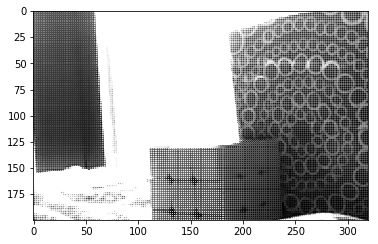

basic color image


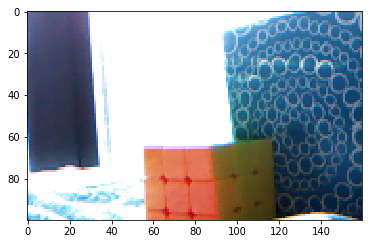

range of exposures


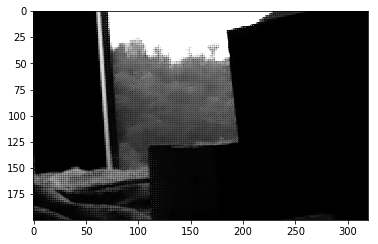

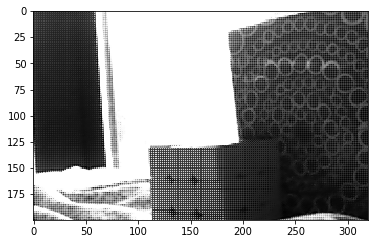

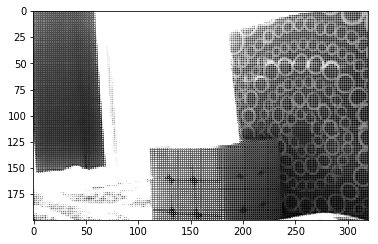

In [99]:
# Get images
print("basic raw image")
plt.imshow(get_raw_image()); plt.show()

print("basic color image")
plt.imshow(get_color_image()); plt.show()

num_img = 20;

[images, exposure_times] = get_images(num_img)
print("range of exposures")
plt.imshow(images[0]); plt.show();
plt.imshow(images[len(images)/2]); plt.show();
plt.imshow(images[-1]); plt.show();

max pixel value=163.02203809
pixel_value vs exposure


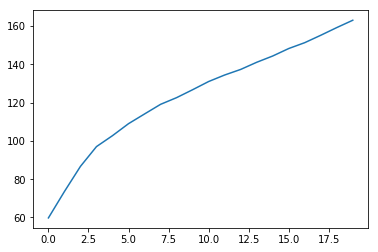

In [30]:
# Display calibration curve
[pixel_values, max_pixel_value] = get_calibration_curve_from_images(images, 0,-1)
print("pixel_value vs exposure"); 
plt.plot(pixel_values);
plt.show();

In [31]:
# Precompute some stuff (mainly weight sums for each pixel)
height = len(images[0])
width = len(images[0][0])
w = make_w(0, 255)

start = time.time()
wsums = get_weight_sums(images, w)
end = time.time()
print("got weight sums, time="+str(end-start))
print("max weight sum=" + str(numpy.amax(wsums)))

got weight sums, time=30.39944911
max weight sum=1706.0


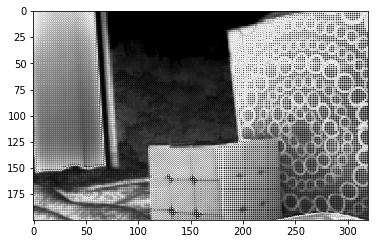

In [32]:
# Visualize weight sums
plt.imshow(wsums); plt.show();

In [33]:
# Construct HDR img

def process(r,c):
#     return get_radiance_ln(images, exposure_times, w, wsums, r, c)
    return get_radiance(images, exposure_times, w, wsums, r, c)
    
def processRow(r):
    print(r),
    return [process(r,c) for c in range(width)]
    
print("start constructing hdr image")
start = time.time();
new_image = [processRow(r) for r in range(height)]
end = time.time()
print("")
print("time=" + str(end - start))

start constructing hdr image
0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95 96 97 98 99 100 101 102 103 104 105 106 107 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143 144 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161 162 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179 180 181 182 183 184 185 186 187 188 189 190 191 192 193 194 195 196 197 198 199 
time=35.6987080574


raw hdr image (may not be 'accurate')


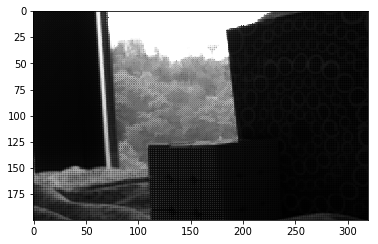

max pixel=255.0
min pixel=1.20848298736


In [34]:
# Display raw HDR image
print("raw hdr image (may not be 'accurate')")
plt.imshow(new_image);plt.show();

print("max pixel=" + str(numpy.amax(new_image)))
print("min pixel=" + str(numpy.amin(new_image)))

tone mapping, grayscale


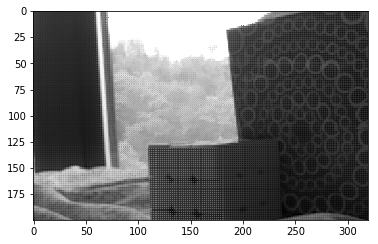

tone mapping, color, normalize all vals to [0,1]


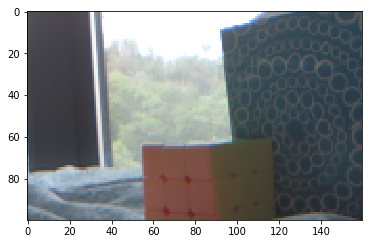

In [91]:
# Gamma tone-mapping (grayscale)

# Attempt at using widgets
# print("adjust gamma")
# gamma_slider = widgets.FloatSlider(min=0, max=2, step=0.1, value=0.4)
# display(gamma_slider)
# gamma = gamma_slider.value

gamma = 0.4
toned = tone_map(new_image, gamma,2)
print("tone mapping, grayscale")
plt.imshow(toned); plt.show();

# Gamma tone-mapping (color)
toned_color = raw2color(numpy.array(toned))
print("tone mapping, color, normalize all vals to [0,1]")
final_color = toned_color *(1.0/numpy.amax(toned_color))
plt.imshow(final_color); plt.show();

max raw=9.17521124876
max color=9.17521124876
toned color


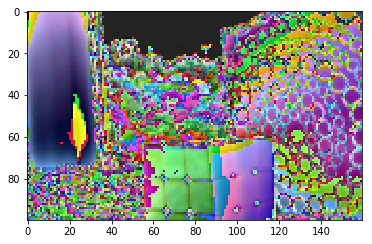

toned color / 3


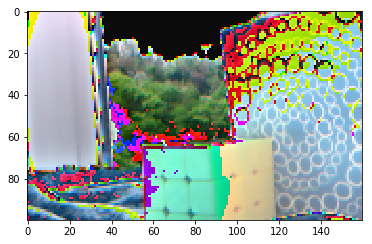

toned color, color channels each / 3


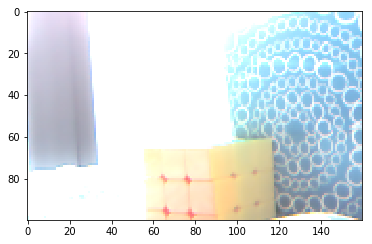

toned color, normalize all vals to [0,1]


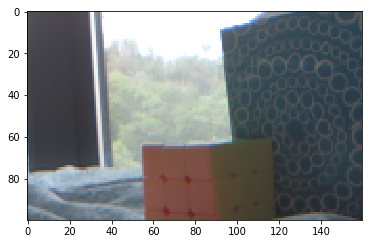

In [37]:
# Try various ways to display tone mapped image

# convert tone mapped raw to color
toned2 = numpy.array(toned)
toned_color = raw2color(toned2)
toned_color_2 = raw2color_2(toned2)
print("max raw=" + str(numpy.amax(toned2)))
print("max color=" + str(numpy.amax(toned_color)))

print("toned color")
plt.imshow(toned_color);plt.show();   

print("toned color / 3")
plt.imshow(toned_color/3);plt.show();   

# not bad sometimes
print("toned color, color channels each / 3")
plt.imshow(toned_color_2);plt.show();   

# print("toned color / 255^gamma")
# plt.imshow(toned_color/(1.0**gamma)); plt.show();
# plt.imshow(get_color_image());plt.show()



display directly


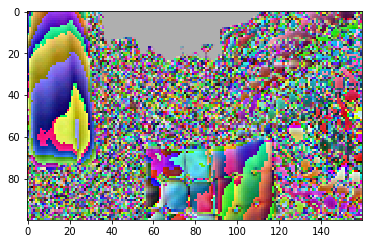

normalized to [0,1]


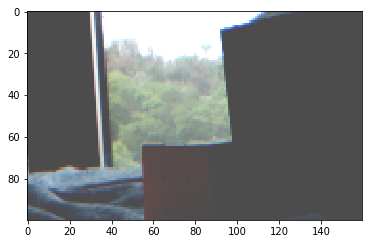